# MobileNet v3

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

# Check if MPS (Apple Silicon) or CUDA is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data transformations (96x96 resizing)
data_transforms = transforms.Compose([
    transforms.Resize((96, 96)),            # Resize to 96x96 pixels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset (without splitting into train/val yet)
# data_dir = '/Users/shingkai/code/personal-projects/mk8/training_data/items'
data_dir = r'C:\Users\mikes\code\MarioKart8CV\items'
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))   # 80% training
val_size = len(full_dataset) - train_size   # 20% validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get number of classes
num_classes = len(full_dataset.classes)

# Load MobileNetV3-large pre-trained model
model = models.mobilenet_v3_large(weights='DEFAULT')

# Modify the last fully connected layer to match the number of classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Move model to the GPU if available
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Fine-tune the model
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), 'mobilenetv3_finetuned.pth')

Epoch 1/10
----------
train Loss: 0.1102 Acc: 0.9743
val Loss: 0.0570 Acc: 0.9903
Epoch 2/10
----------
train Loss: 0.0451 Acc: 0.9893
val Loss: 0.0769 Acc: 0.9752
Epoch 3/10
----------
train Loss: 0.0289 Acc: 0.9929
val Loss: 0.0219 Acc: 0.9958
Epoch 4/10
----------
train Loss: 0.0197 Acc: 0.9961
val Loss: 0.0279 Acc: 0.9943
Epoch 5/10
----------
train Loss: 0.0040 Acc: 0.9992
val Loss: 0.0361 Acc: 0.9955
Epoch 6/10
----------
train Loss: 0.0075 Acc: 0.9981
val Loss: 0.0252 Acc: 0.9961
Epoch 7/10
----------
train Loss: 0.0833 Acc: 0.9865
val Loss: 1.0120 Acc: 0.8728
Epoch 8/10
----------
train Loss: 0.0309 Acc: 0.9921
val Loss: 0.0234 Acc: 0.9958
Epoch 9/10
----------
train Loss: 0.0126 Acc: 0.9975
val Loss: 0.0164 Acc: 0.9943
Epoch 10/10
----------
train Loss: 0.0220 Acc: 0.9952
val Loss: 0.0404 Acc: 0.9940
Best val Acc: 0.996071


In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
import cv2
from PIL import Image
import numpy as np

classes = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '13', '14', '16', '17', '18', '20', '21', '23', '24']

# Check if MPS (Apple Silicon) or CUDA is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned MobileNetV3 model
num_classes = len(classes)  # Change this based on your number of classes
model = models.mobilenet_v3_large(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.load_state_dict(torch.load('mobilenetv3_finetuned.pth', weights_only=True))
model = model.to(device)
model.eval()

# Transform for inference (96x96 resizing and normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),  # Resize to 96x96 pixels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to run inference on a cv2 frame
def predict_frame(frame):

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0).to(device)

    # Run the model in evaluation mode
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class
    predicted_class = classes[predicted.item()]
    return predicted_class


Predicted class: 24


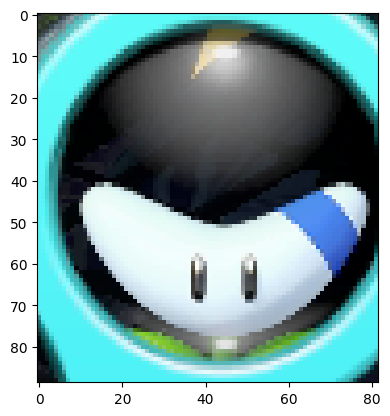

In [26]:
import matplotlib.pyplot as plt
import cv2

# image_path = '/Users/shingkai/code/personal-projects/mk8/race_videos/training/mirror_flower_cup/p1_first_item/0/020094.png'
# image_path = '/Users/shingkai/code/personal-projects/mk8/race_videos/training/mirror_flower_cup/p1_first_item/0/026030.png'
# image_path = '/Users/shingkai/code/personal-projects/mk8/race_videos/training/mirror_flower_cup/p1_first_item/0/025855.png'

# image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\013088.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\000072.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\002928.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\002992.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\003460.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\021376.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\021424.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\021472.png'
image_path = r'C:\Users\mikes\code\MarioKart8CV\race_videos\training\item2\Player.P2\021504.png'


frame = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
predicted_class = predict_frame(frame)
print(f"Predicted class: {predicted_class}")
